In [3]:
import os
import glob
def get_obs_file_pairs(obs_folder, obs_names):
    """
    Collects file1, file2, and gti paths for each observation.
    
    Args:
        obs_folder (str): Path to the folder containing observations.
        obs_names (list): List of observation directory names.
        file1_suffix (str): Filename suffix for file1.
        file2_suffix (str): Filename suffix for file2.
        gti_suffix (str): Filename suffix for GTI file.

    Returns:
        list of tuples: [(file1, file2, gti), ...]
    """
    obs_triplets = []
    for obs in obs_names:
        full_dir = os.path.join(obs_folder, obs)
        gti_path  = os.path.join(full_dir,  f"GTI_ixpe{obs}_evt2_v0*.txt")
        gti = glob.glob(gti_path)[0]
        full_dir = os.path.join(full_dir, "event_1pt5")
        file1_path = os.path.join(full_dir,  f"ixpe{obs}_det12*.fits")
        #print(file1_path)
        file1 = glob.glob(file1_path)[0]
        file2_path = os.path.join(full_dir, f"ixpe{obs}_det3*.fits")
        file2 = glob.glob(file2_path)[0]
        obs_triplets.append((file1, file2, gti))
    return obs_triplets


obs_dir='/home/c2032014/cygx1_paper/cyg_data_all'
obs_names=['01002901','01250101','03002201','03003101','03010001','03010101']
obs_triplets=get_obs_file_pairs(obs_dir, obs_names)

print(obs_triplets[0])

('/home/c2032014/cygx1_paper/cyg_data_all/01002901/event_1pt5/ixpe01002901_det12_event_1pt5_src.fits', '/home/c2032014/cygx1_paper/cyg_data_all/01002901/event_1pt5/ixpe01002901_det3_evt_1pt5_v01_src.fits', '/home/c2032014/cygx1_paper/cyg_data_all/01002901/GTI_ixpe01002901_evt2_v01.txt')


In [4]:
from joblib import Parallel, delayed
import numpy as np
import sys
sys.path.append('/home/c2032014/py_files/')
import numpy as np
import load_and_clean as lac
import rms_normalisation as rn
from stingray import Lightcurve, Powerspectrum, AveragedCrossspectrum
import dG_span_new_abs as dgs
import G_span_abs as gs
import frac_rms_span as frmss
import phase_span as phs
import fit_rms_phase as frp
import F_test as ft
import frac_rms_err_span as fres
import phase_err_span as pes
import chi_square as chis
import importlib
importlib.reload(frp)
importlib.reload(ft)
importlib.reload(gs)
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import load_and_clean as lac
from stingray import Lightcurve, Powerspectrum, AveragedCrossspectrum
from joblib import Parallel, delayed
import numpy as np
import sys
sys.path.append('/home/c2032014/py_files/')
import numpy as np
import load_and_clean as lac
import rms_normalisation as rn
from stingray import Lightcurve, Powerspectrum, AveragedCrossspectrum
import dG_span_new_abs as dgs
import G_span_abs as gs
import frac_rms_span as frmss
import phase_span as phs
import fit_rms_phase as frp
import F_test as ft
import frac_rms_err_span as fres
import phase_err_span as pes
import chi_square as chis
import importlib
importlib.reload(frp)
importlib.reload(ft)
importlib.reload(gs)
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


norm='abs'
fmin=1
fmax=2
f_bin_number=4
Pmin=51
Pmax=200
gti_obs1='/home/c2032014/CYGX1/event_1pt5/GTI_ixpe01002901_evt1pt5_v01_src.txt'
gti_obs2='/home/c2032014/cyg_june/CYGX1_JUNE/event_1pt5/GTI_ixpe01250101_evt1pt5_v01_src.txt'
bin_length=1/64
seg_length=16
fmin=0
fmax=4
f_bin_number=2
mod_min=np.radians(-90)
mod_max=np.radians(90)
mod_bin_number=20
J=mod_bin_number
spur_sub=True
coherence_corrector=False
output_file='/home/c2032014/cygx1_paper/stacked_qu_test_1bin.npy'

#Making frequency list
fspace = np.linspace(fmin, fmax, f_bin_number + 1)
f_min_array, f_max_array = fspace[:-1], fspace[1:]
f_angle_list = list(zip(f_min_array, f_max_array))
av_f = (f_min_array + f_max_array) / 2
av_f_err = (f_max_array - f_min_array) / 2

#Making modulation angle list

aspace = np.linspace(mod_min, mod_max, mod_bin_number + 1)
mod_min_array = aspace[:-1]
mod_max_array = aspace[1:]
av_mod = (mod_min_array + mod_max_array) / 2
av_mod_err = (mod_max_array - mod_min_array) / 2

#Defining models we want to fit
def cross_spec_model_real(phi, A, B, C):
        return (1/J) * (A + B * np.cos(2 * phi) + C * np.sin(2 * phi))

def cross_spec_model_imag(phi, B, C):
    return (1/J) * (B * np.cos(2 * phi) + C * np.sin(2 * phi))

def cross_spec_model_null(phi, C_nu_mag_sqrd):
    return (1/J) * C_nu_mag_sqrd * (1 + Q_norm * np.cos(2 * phi) + U_norm * np.sin(2 * phi))


cs_G_obs=[]
cs_ref_obs=[]

I_obs_arr=[]
Q_obs_arr=[]
U_obs_arr=[]
for obs in obs_triplets:
        """
        Here we calculate all the data products we need from each observation, which we then 
        average over each frequency range and stack.

        We clean each observation, make lightcurves of DU1+DU2 and DU3, then calculate the reference band 
        powerspectrum and reference band cross spectrum. We then calculate the cs corresponding to G, but we wait till were 
        in the frequency loop before we average that part.
        
        
        
        """
        print(obs)
        data1, *_ = lac.load_and_clean(obs[0], Pmin, Pmax)
        data2, *_ = lac.load_and_clean(obs[1], Pmin, Pmax)
        GTI = list(np.loadtxt(obs[2]))

        I_obs=len(data1['TIME'])
        Q_obs=data1['Q']
        U_obs=data1['U']

        I_obs_arr.append(I_obs)
        Q_obs_arr.append(Q_obs)
        U_obs_arr.append(U_obs)



        lc1 = Lightcurve.make_lightcurve(data1['TIME'], dt=bin_length, gti=GTI)
        lc2 = Lightcurve.make_lightcurve(data2['TIME'], dt=bin_length, gti=GTI)
        lc1.apply_gtis()
        lc2.apply_gtis()

        #ps = Powerspectrum.from_lightcurve(lc2, seg_length, norm='abs')
        cs_ref = AveragedCrossspectrum.from_lightcurve(lc1, lc2, seg_length, norm='abs')
        cs_ref_obs.append(cs_ref)
        _, _, _, _, _,_,cs,_ =gs.G_span(mod_bin_number,data1,lc2,GTI,bin_length,seg_length,fmin,fmax,spur_sub,norm)
        cs_G_obs.append(cs)
        #print(cs)
        #for i in range(len(cs)):
        #   
        #    cs[i].m=cs[i].m
        #    print(cs[i].m)
A_real=[]
B_real=[]
C_real=[]

A_real_err_arr=[]
B_real_err_arr=[]
C_real_err_arr=[]

B_imag=[]
C_imag=[]
B_imag_err_arr=[]
C_imag_err_arr=[]

A_null_real_arr=[]
B_null_real_arr=[]
C_null_real_arr=[]

B_null_imag_arr=[]
C_null_imag_arr=[]


I_tot=np.sum(I_obs_arr)
Q_norm=sum(sum(sublist) for sublist in Q_obs_arr)/I_tot
#Q_tot=np.sum([q for q in sublist] for sublist in Q_obs_arr)/I_tot
#U_tot=np.sum(U_obs_arr)/I_tot
#U_tot=np.sum([u for u in sublist] for sublist in U_obs_arr)/I_tot   
U_norm=sum(sum(sublist) for sublist in U_obs_arr)/I_tot

for freq_bin in f_angle_list:

    weights_G=[[cs.m for cs in sublist] for sublist in cs_G_obs]
    #print(weights_G)
    weights_ref=[cs.m for cs in cs_ref_obs]
    fmin, fmax = freq_bin
    #cs_G_obs_freq = [cs for cs in cs_G_obs if (fmin <= cs.freq) & (cs.freq <= fmax)]
    
    # Averaging over the frequency range


    G_real = np.average([[cs.power.real[(fmin <= cs.freq) & (cs.freq <= fmax)].mean() for cs in sublist] for sublist in cs_G_obs],weights=weights_G,axis=0)
    G_imag = np.average([[cs.power.imag[(fmin <= cs.freq) & (cs.freq <= fmax)].mean() for cs in sublist] for sublist in cs_G_obs],weights=weights_G,axis=0)
    cs_ref_real_mean=np.average([cs_ref.power.real[(fmin <= cs_ref.freq) & (cs_ref.freq <= fmax)].mean() for cs_ref in cs_ref_obs],weights=weights_ref,axis=0)
    cs_ref_imag_mean=np.average([cs_ref.power.imag[(fmin <= cs_ref.freq) & (cs_ref.freq <= fmax)].mean() for cs_ref in cs_ref_obs],weights=weights_ref,axis=0)
    cs_ref_average=cs_ref_real_mean+1j*cs_ref_imag_mean
    cs_ref_abs_mean_stack=np.abs(cs_ref_average)
    print('G real',G_real)
    print('G imag',G_imag)

    # Fit real part of G
    params_real, cov_real = curve_fit(cross_spec_model_real, np.array(av_mod), np.array(G_real))
    A_real_val, B_real_val, C_real_val = params_real
    A_real.append(A_real_val)
    B_real.append(B_real_val)
    C_real.append(C_real_val)

    fit_real = cross_spec_model_real(np.array(av_mod), A_real_val, B_real_val, C_real_val)

    # Estimate uncertainties from covariance
    A_real_err, B_real_err, C_real_err = np.sqrt(np.diag(cov_real))
    A_real_err_arr.append(A_real_err)
    B_real_err_arr.append(B_real_err)
    C_real_err_arr.append(C_real_err)

    # Fit imaginary part of G
    params_imag, cov_imag = curve_fit(cross_spec_model_imag, np.array(av_mod), np.array(G_imag))
    B_imag_val, C_imag_val = params_imag
    B_imag.append(B_imag_val)
    C_imag.append(C_imag_val)

    # Estimate uncertainties from covariance
    B_imag_err, C_imag_err = np.sqrt(np.diag(cov_imag))
    B_imag_err_arr.append(B_imag_err)
    C_imag_err_arr.append(C_imag_err)


    fit_imag = cross_spec_model_imag(np.array(av_mod), B_imag_val, C_imag_val)
    G_null=cross_spec_model_null(np.array(av_mod),cs_ref_abs_mean_stack)
    G_null_real=G_null.real
    G_null_imag=G_null.imag


    A_null_real=cs_ref_abs_mean_stack
    B_null_real=cs_ref_abs_mean_stack*Q_norm
    C_null_real=cs_ref_abs_mean_stack*U_norm

    A_null_real_arr.append(A_null_real)
    B_null_real_arr.append(B_null_real)
    C_null_real_arr.append(C_null_real)
    B_null_imag=0
    C_null_imag=0
    B_null_imag_arr.append(B_null_imag)


    plt.figure()
    plt.title('Real')
    plt.errorbar(av_mod,G_real,xerr=av_mod_err,ls='None',label='Real')
    plt.plot(av_mod,G_null_real,label='Null')
    plt.plot(av_mod,fit_real,label='fit')
    plt.legend()
    plt.show()
   
    plt.figure()
    plt.title('Imaginary')
    plt.errorbar(av_mod,G_imag,xerr=av_mod_err,ls='None',label='Imaginary')
    plt.plot(av_mod,fit_imag,label='fit')
    plt.plot(av_mod,G_null_imag,label='Null')
    plt.legend()
    plt.show()

plt.figure()
plt.title('Real')
plt.errorbar(av_f,A_real,xerr=av_f_err,yerr=A_real_err_arr,ls='None',label='A')
plt.plot(av_f,A_real,label='A')
plt.legend()
plt.figure()
plt.title('Real')
plt.plot(av_f,B_real,label='B')
plt.errorbar(av_f,B_real,xerr=av_f_err,yerr=B_real_err_arr,ls='None',label='B')
plt.plot(av_f,C_real,label='C')
plt.errorbar(av_f,C_real,xerr=av_f_err,yerr=C_real_err_arr,ls='None',label='C')
plt.legend()

plt.figure()
plt.title('Imaginary')
plt.plot(av_f,B_imag,label='B')
plt.errorbar(av_f,B_imag,xerr=av_f_err,yerr=B_imag_err_arr,ls='None',label='B')
plt.plot(av_f,C_imag,label='C')
plt.errorbar(av_f,C_imag,xerr=av_f_err,yerr=C_imag_err_arr,ls='None',label='C')
plt.legend()

#print(A_real,A_real_err_arr,B_real,B_real_err_arr,C_real,C_real_err_arr,B_imag,B_imag_err_arr,C_imag,C_imag_err_arr,av_f,av_f_err,A_null_real_arr,B_null_real_arr,C_null_real_arr,B_null_imag_arr,C_null_imag_arr)
results=np.array(tuple(zip(A_real,A_real_err_arr,B_real,B_real_err_arr,C_real,C_real_err_arr,B_imag,B_imag_err_arr,C_imag,C_imag_err_arr,av_f,av_f_err,A_null_real_arr,B_null_real_arr,C_null_real_arr,B_null_imag_arr,C_null_imag_arr)))
np.save(output_file,results)
      



('/home/c2032014/cygx1_paper/cyg_data_all/01002901/event_1pt5/ixpe01002901_det12_event_1pt5_src.fits', '/home/c2032014/cygx1_paper/cyg_data_all/01002901/event_1pt5/ixpe01002901_det3_evt_1pt5_v01_src.fits', '/home/c2032014/cygx1_paper/cyg_data_all/01002901/GTI_ixpe01002901_evt2_v01.txt')
num of events 9678551


KeyboardInterrupt: 

In [17]:
def Q_U_NU_stack(
    obs_file_pairs,  # List of (file1, file2)
    gti_files,       # List of GTI file paths
    mod_bin_number, Pmin, Pmax,
    bin_length, seg_length, f_min, f_max,
    spur_sub, save=False, save_name="stacked"
):
    import numpy as np
    import matplotlib.pyplot as plt
    from stingray import Lightcurve, Powerspectrum, AveragedCrossspectrum
    import lac_functions as lac
    import G_span as gs
    from fit_sin import fit_sin

    cs_real_means, cs_im_means, ps_means, m_values = [], [], [], []
    G_real_spans, G_im_spans, m_spans, n_spans, lc1_sub_spans = [], [], [], [], []

    I_total = 0
    Q_total = 0
    U_total = 0

    # Loop over observations
    for (file1, file2), gti_file in zip(obs_file_pairs, gti_files):
        data1, _ = lac.load_and_clean(file1, Pmin, Pmax)
        data2, _ = lac.load_and_clean(file2, Pmin, Pmax)
        GTI = list(np.loadtxt(gti_file))

        lc1 = Lightcurve.make_lightcurve(data1['TIME'], dt=bin_length, gti=GTI)
        lc2 = Lightcurve.make_lightcurve(data2['TIME'], dt=bin_length, gti=GTI)
        lc1.apply_gtis()
        lc2.apply_gtis()

        ps = Powerspectrum.from_lightcurve(lc2, seg_length, norm='abs')
        cs = AveragedCrossspectrum.from_lightcurve(lc1, lc2, seg_length, norm='abs')

        freq_mask = (f_min <= ps.freq) & (ps.freq <= f_max)
        ps_means.append(ps.power[freq_mask].mean())
        cs_real_means.append(cs.power.real[freq_mask].mean())
        cs_im_means.append(cs.power.imag[freq_mask].mean())
        m_values.append(cs.m)

        G_real_span, G_im_span, n_span, m_span, lc1_sub_span, *_ = gs.G_span(
            mod_bin_number, data1, lc2, GTI, bin_length, seg_length,
            f_min, f_max, spur_sub, 'abs'
        )
        G_real_spans.append(G_real_span)
        G_im_spans.append(G_im_span)
        m_spans.append(m_span)
        n_spans.append(n_span)
        lc1_sub_spans.append(lc1_sub_span)

        # Stokes integration
        I_total += len(data1['TIME']) + len(data2['TIME'])
        Q_total += np.sum(data1['Q']) + np.sum(data2['Q'])
        U_total += np.sum(data1['U']) + np.sum(data2['U'])

    # Weighted stacking
    cs_real_mean_stack = np.average(cs_real_means, weights=m_values)
    cs_im_mean_stack = np.average(cs_im_means, weights=m_values)
    cs_abs_mean_stack = np.abs(cs_real_mean_stack + 1j * cs_im_mean_stack)
    ps_mean_stack = np.average(ps_means, weights=m_values)

    G_real_span_stack = np.average(G_real_spans, axis=0, weights=m_spans)
    G_im_span_stack = np.average(G_im_spans, axis=0, weights=m_spans)

    # Fit sinusoidal models
    A_real, B_real = fit_sin(G_real_span_stack)
    A_im, B_im = fit_sin(G_im_span_stack)

    # Null model
    G_real_null = A_real * np.cos(2 * np.pi * np.arange(mod_bin_number) / mod_bin_number)
    G_im_null = A_im * np.sin(2 * np.pi * np.arange(mod_bin_number) / mod_bin_number)

    # Normalize Q and U
    Q_norm = Q_total / I_total
    U_norm = U_total / I_total

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(G_real_span_stack, label='Real')
    plt.plot(G_im_span_stack, label='Imag', color='orange')
    plt.plot(G_real_null, '--', label='Real (null)', color='blue')
    plt.plot(G_im_null, '--', label='Imag (null)', color='red')
    plt.xlabel('Phase Bin')
    plt.ylabel('Cross Spectrum Amplitude')
    plt.title(f"Stacked G_real and G_im (|cs| = {cs_abs_mean_stack:.2f})")
    plt.legend()
    if save:
        plt.savefig(f"{save_name}_G_span.png", dpi=300)
    plt.show()

    # Return results
    return {
        "Q": Q_norm,
        "U": U_norm,
        "cs_abs_mean": cs_abs_mean_stack,
        "ps_mean": ps_mean_stack,
        "G_real_span_stack": G_real_span_stack,
        "G_im_span_stack": G_im_span_stack,
        "n_spans": n_spans,
        "m_spans": m_spans,
        "lc1_sub_spans": lc1_sub_spans
    }


In [6]:
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def Q_U_NU_stack(file1_obs1, file2_obs1,
                 file1_obs2, file2_obs2,
                 Pmin, Pmax, gti_obs1, gti_obs2, bin_length, seg_length,
                 fmin, fmax, f_bin_number, mod_min, mod_max, mod_bin_number,
                 J, spur_sub, coherence_corrector, output_file, stack=True, n_jobs=-1):
    
    # Frequency bins
    fspace = np.linspace(fmin, fmax, f_bin_number + 1)
    f_angle_list = [(fspace[i-1], fspace[i]) for i in range(1, len(fspace))]
    f_min_array = fspace[:-1]
    f_max_array = fspace[1:]
    av_f = (f_min_array + f_max_array) / 2
    av_f_err = (f_max_array - f_min_array) / 2

    # Modulation bins
    aspace = np.linspace(mod_min, mod_max, mod_bin_number + 1)
    mod_min_array = aspace[:-1]
    mod_max_array = aspace[1:]
    av_mod = (mod_min_array + mod_max_array) / 2
    av_mod_err = (mod_max_array - mod_min_array) / 2

    # Load GTIs
    GTI_obs1 = list(np.loadtxt(str(gti_obs1)))
    GTI_obs2 = list(np.loadtxt(str(gti_obs2)))

    # Load and clean event data
    data_1_obs1, *_ = lac.load_and_clean(file1_obs1, Pmin, Pmax)
    data_2_obs1, *_ = lac.load_and_clean(file2_obs1, Pmin, Pmax)
    data_1_obs2, *_ = lac.load_and_clean(file1_obs2, Pmin, Pmax)
    data_2_obs2, *_ = lac.load_and_clean(file2_obs2, Pmin, Pmax)

    # Lightcurves for full mod bins
    lc_1_ref_obs1 = Lightcurve.make_lightcurve(data_1_obs1['TIME'], dt=bin_length, gti=GTI_obs1)
    lc_1_ref_obs1.apply_gtis()
    lc_2_ref_obs1 = Lightcurve.make_lightcurve(data_2_obs1['TIME'], dt=bin_length, gti=GTI_obs1)
    lc_2_ref_obs1.apply_gtis()
    lc_1_ref_obs2 = Lightcurve.make_lightcurve(data_1_obs2['TIME'], dt=bin_length, gti=GTI_obs2)
    lc_1_ref_obs2.apply_gtis()
    lc_2_ref_obs2 = Lightcurve.make_lightcurve(data_2_obs2['TIME'], dt=bin_length, gti=GTI_obs2)
    lc_2_ref_obs2.apply_gtis()

    # Fourier products
    ps_2_ref_obs1 = Powerspectrum.from_lightcurve(lc_2_ref_obs1, seg_length, norm='abs')
    cs_ref_obs1 = AveragedCrossspectrum.from_lightcurve(lc_1_ref_obs1, lc_2_ref_obs1, seg_length, norm='abs')
    ps_2_ref_obs2 = Powerspectrum.from_lightcurve(lc_2_ref_obs2, seg_length, norm='abs')
    cs_ref_obs2 = AveragedCrossspectrum.from_lightcurve(lc_1_ref_obs2, lc_2_ref_obs2, seg_length, norm='abs')

    # Normalized Stokes
    I = sum(len(d['TIME']) for d in [data_1_obs1, data_2_obs1, data_1_obs2, data_2_obs2])
    Q_norm = sum(np.sum(d['Q']) for d in [data_1_obs1, data_2_obs1, data_1_obs2, data_2_obs2]) / I
    U_norm = sum(np.sum(d['U']) for d in [data_1_obs1, data_2_obs1, data_1_obs2, data_1_obs2]) / I

    def cross_spec_model_real(phi, A, B, C):
        return (1/J) * (A + B * np.cos(2 * phi) + C * np.sin(2 * phi))

    def cross_spec_model_imag(phi, B, C):
        return (1/J) * (B * np.cos(2 * phi) + C * np.sin(2 * phi))

    def cross_spec_model_null(phi, C_nu_mag_sqrd):
        return (1/J) * C_nu_mag_sqrd * (1 + Q_norm * np.cos(2 * phi) + U_norm * np.sin(2 * phi))

    def process_freq_bin(i, f_min, f_max):
        ps_2_mean_obs1 = ps_2_ref_obs1.power[(f_min <= ps_2_ref_obs1.freq) & (ps_2_ref_obs1.freq <= f_max)].mean()
        ps_2_mean_obs2 = ps_2_ref_obs2.power[(f_min <= ps_2_ref_obs2.freq) & (ps_2_ref_obs2.freq <= f_max)].mean()

        cs_r_obs1 = cs_ref_obs1.power.real[(f_min <= cs_ref_obs1.freq) & (cs_ref_obs1.freq <= f_max)].mean()
        cs_i_obs1 = cs_ref_obs1.power.imag[(f_min <= cs_ref_obs1.freq) & (cs_ref_obs1.freq <= f_max)].mean()
        cs_r_obs2 = cs_ref_obs2.power.real[(f_min <= cs_ref_obs2.freq) & (cs_ref_obs2.freq <= f_max)].mean()
        cs_i_obs2 = cs_ref_obs2.power.imag[(f_min <= cs_ref_obs2.freq) & (cs_ref_obs2.freq <= f_max)].mean()

        m1, m2 = cs_ref_obs1.m, cs_ref_obs2.m
        cs_r_stack = (m1 * cs_r_obs1 + m2 * cs_r_obs2) / (m1 + m2)
        cs_i_stack = (m1 * cs_i_obs1 + m2 * cs_i_obs2) / (m1 + m2)
        cs_abs_stack = np.abs(cs_r_stack + 1j * cs_i_stack)

        ps_2_stack = (ps_2_ref_obs1.m * ps_2_mean_obs1 + ps_2_ref_obs2.m * ps_2_mean_obs2) / (ps_2_ref_obs1.m + ps_2_ref_obs2.m)

        G_r1, G_i1, n1, m1_span, lc1_mod1, *_ = gs.G_span(mod_bin_number, data_1_obs1, lc_2_ref_obs1, GTI_obs1, bin_length, seg_length, f_min, f_max, spur_sub, 'abs')
        G_r2, G_i2, n2, m2_span, lc1_mod2, *_ = gs.G_span(mod_bin_number, data_1_obs2, lc_2_ref_obs2, GTI_obs2, bin_length, seg_length, f_min, f_max, spur_sub, 'abs')

        G_r_stack = (m1_span * G_r1 + m2_span * G_r2) / (m1_span + m2_span)
        G_i_stack = (m1_span * G_i1 + m2_span * G_i2) / (m1_span + m2_span)

        dG = dgs.dG_span(G_r_stack, G_i_stack, lc1_mod1, n1, m1_span, f_min, f_max, seg_length, ps_2_stack, cs_r_stack, coherence_corrector, 'abs', stack, lc1_mod2, n1, n2, m1_span, m2_span)

        popt_r, pcov_r = curve_fit(cross_spec_model_real, av_mod, G_r_stack)
        popt_i, pcov_i = curve_fit(cross_spec_model_imag, av_mod, G_i_stack)

        A, B_r, C_r = popt_r
        B_i, C_i = popt_i
        A_err, B_r_err, C_r_err = np.sqrt(np.diag(pcov_r))
        B_i_err, C_i_err = np.sqrt(np.diag(pcov_i))

        A_null = cs_abs_stack
        B_null = cs_abs_stack * Q_norm
        C_null = cs_abs_stack * U_norm

        return (A, A_err, B_r, B_r_err, C_r, C_r_err,
                B_i, B_i_err, C_i, C_i_err,
                av_f[i], av_f_err[i],
                A_null, B_null, C_null, 0, 0)

    results = Parallel(n_jobs=n_jobs)(
        delayed(process_freq_bin)(i, fmin_i, fmax_i)
        for i, (fmin_i, fmax_i) in enumerate(f_angle_list)
    )

    results_array = np.array(results)
    np.save(output_file, results_array)

    # Unpack for plotting
    (A_real, A_real_err, B_real, B_real_err,
     C_real, C_real_err, B_imag, B_imag_err,
     C_imag, C_imag_err, av_f_vals, av_f_errs,
     A_nulls, B_nulls, C_nulls, *_zeros) = results_array.T

    # Plotting
    plt.figure()
    plt.title('Real')
    plt.errorbar(av_f_vals, A_real, xerr=av_f_errs, yerr=A_real_err, fmt='.', label='A')
    plt.errorbar(av_f_vals, B_real, xerr=av_f_errs, yerr=B_real_err, fmt='.', label='B')
    plt.errorbar(av_f_vals, C_real, xerr=av_f_errs, yerr=C_real_err, fmt='.', label='C')
    plt.legend()

    plt.figure()
    plt.title('Imaginary')
    plt.errorbar(av_f_vals, B_imag, xerr=av_f_errs, yerr=B_imag_err, fmt='.', label='B')
    plt.errorbar(av_f_vals, C_imag, xerr=av_f_errs, yerr=C_imag_err, fmt='.', label='C')
    plt.legend()

    return results_array


In [23]:
import sys
sys.path.append('/home/c2032014/cygx1_paper/')
import Q_U_NU_NEW_STACK_ABS as qun
import importlib
importlib.reload(qun)
norm='abs'
qun.run_q_u_nu_stack(obs_dir, obs_names, Pmin, Pmax, bin_length,
                                seg_length, fmin, fmax,f_bin_number,
                                mod_bin_number, mod_min,mod_max,spur_sub, coherence_corrector,norm,
                                output_file)


num of events 1701018
num of events 3883959
num of events 785926
num of events 9678551
num of events 1807055
num of events 1365526
num of events 1777702
num of events 1813589
num of events 632960
num of events 842912
num of events 823553
num of events 4450960


TypeError: cross_spec_model_real() takes 5 positional arguments but 21 were given

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import scipy
from scipy.optimize import curve_fit

#Importing my functions
import sys
sys.path.append('/home/c2032014/py_files')
import load_and_clean as lac
import fit_rms_phase as frp
import F_test as ft
import chi_square as chis
import get_obs_file_triplets as g
import get_obs_file_triplets as gft
import G_span_abs as gs
#Importing parallel processing packages
from joblib import Parallel, delayed

#Importing stingray packages
from stingray import Lightcurve, Powerspectrum, AveragedCrossspectrum


# Example function to process one observation triplet
def process_obs_triplet(obs, Pmin, Pmax, bin_length,
                        seg_length, fmin, fmax,spur_sub,
                        norm,mod_bin_number,mod_min,mod_max,
                        coherence_corrector=None):
    


    #print(obs)
    data1, *_ = lac.load_and_clean(obs[0], Pmin, Pmax)
    data2, *_ = lac.load_and_clean(obs[1], Pmin, Pmax)
    GTI = list(np.loadtxt(obs[2]))

    I_obs = len(data1['TIME'])
    Q_obs = data1['Q']
    U_obs = data1['U']

    Q_norm = np.sum(Q_obs) / I_obs
    U_norm = np.sum(U_obs) / I_obs

    # Loading and cleaning data


    lc1 = Lightcurve.make_lightcurve(data1['TIME'], dt=bin_length, gti=GTI)
    lc2 = Lightcurve.make_lightcurve(data2['TIME'], dt=bin_length, gti=GTI)
    lc1.apply_gtis()
    lc2.apply_gtis()

    # cs ref needed for null calculation
    cs_ref = AveragedCrossspectrum.from_lightcurve(lc1, lc2, seg_length, norm='abs')
    ps_2_ref = Powerspectrum.from_lightcurve(lc2, seg_length, norm='abs')
  
    aspace = np.linspace(mod_min, mod_max, mod_bin_number + 1)
    mod_min_array = aspace[:-1]
    mod_max_array = aspace[1:]
    av_mod = (mod_min_array + mod_max_array) / 2
    av_mod_err = (mod_max_array - mod_min_array) / 2
   
    G_real_span, G_im_span, n_span, m_span,lc_1_sub_span,lc_spur,cs,spur_sub_norm = gs.G_span(mod_bin_number, data1, lc2, GTI, bin_length, seg_length, fmin, fmax, spur_sub, norm)




    return {
        "I_obs": I_obs,
        "Q_obs": Q_obs,
        "U_obs": U_obs,
        "Q_norm": Q_norm,
        "U_norm": U_norm,
        "cs_ref": cs_ref,
        "cs_G": cs,
        "weights_ref" : cs_ref.m,
        "weights_G": [cs.m for cs in cs],
        "ps_2_ref": ps_2_ref,
        



    }


#Define sinusoidal models to fit Re[G] and Im[G] 
def cross_spec_model_real(phi,A,B,C):
    Re_G=(1/J) * ( A + (B*np.cos(2*phi)) + (C*np.sin(2*phi)) )
    return Re_G

#The imaginary sinusoid does not have the A term
def cross_spec_model_imag(phi,B,C):
    Im_G=(1/J) * ( (B*np.cos(2*phi)) + (C*np.sin(2*phi)) )
    return Im_G

def cross_spec_model_null(phi, C_nu_mag_sqrd,Q_norm,U_norm):
    return (1/J) * C_nu_mag_sqrd * (1 + Q_norm * np.cos(2 * phi) + U_norm * np.sin(2 * phi))




In [49]:
#Importing basics







obs_triplets = gft.get_obs_file_pairs(obs_dir, obs_names)
# Parallel processing of obs_triplets


results = Parallel(n_jobs=-1)(delayed(process_obs_triplet)(
      obs, Pmin, Pmax, bin_length, seg_length, fmin, fmax,
      spur_sub, norm, mod_bin_number,mod_min,mod_max,
      coherence_corrector=False
  ) for obs in obs_triplets)


#print(results)

aspace = np.linspace(mod_min, mod_max, mod_bin_number + 1)
mod_min_array = aspace[:-1]
mod_max_array = aspace[1:]
av_mod = (mod_min_array + mod_max_array) / 2
av_mod_err = (mod_max_array - mod_min_array) / 2

#Making frequency list
fspace = np.linspace(fmin, fmax, f_bin_number + 1)
f_min_array, f_max_array = fspace[:-1], fspace[1:]
f_angle_list = list(zip(f_min_array, f_max_array))
av_f = (f_min_array + f_max_array) / 2
av_f_err = (f_max_array - f_min_array) / 2


# Unpack the results
I_obs_arr = [r["I_obs"] for r in results]
Q_obs_arr = [r["Q_obs"] for r in results]
U_obs_arr = [r["U_obs"] for r in results]
cs_ref_obs = [r["cs_ref"] for r in results]
cs_G_obs = [r["cs_G"] for r in results]
weights_ref_obs = [r["weights_ref"] for r in results]
weights_G_obs = [r["weights_G"] for r in results]
ps_2_ref = [r["ps_2_ref"] for r in results]

cs_G_obs_real = [[cs.power.real for cs in sublist] for sublist in cs_G_obs]
cs_G_obs_imag = [[cs.power.imag for cs in sublist] for sublist in cs_G_obs]


pr

print('cs_G_obs_real',cs_G_obs_real)
print('cs_G_obs_imag',cs_G_obs_imag)

cs_ref_obs_real = [cs_ref.power.real for cs_ref in cs_ref_obs]
cs_ref_obs_imag = [cs_ref.power.imag for cs_ref in cs_ref_obs]

#print('test',cs_G_obs.freq)

I_tot=np.sum(I_obs_arr)
Q_norm=sum(sum(sublist) for sublist in Q_obs_arr)/I_tot
U_norm=sum(sum(sublist) for sublist in U_obs_arr)/I_tot







   # np.savetxt(output_file, results_freq)

#Now parallelising the frequency binning



num of events 1365526
num of events 1701018
num of events 1777702
num of events 1813589
num of events 3883959
num of events 632960
num of events 785926
num of events 823553
num of events 842912
num of events 1807055
num of events 9678551
num of events 4450960
cs_G_obs_real [[array([ 2.46086809e+00,  2.18998821e+00,  1.60792643e+00,  1.30890316e+00,
        1.00816236e+00,  7.00596759e-01,  7.20420120e-01,  7.03947400e-01,
        6.38453953e-01,  4.86410345e-01,  4.37300775e-01,  3.81900998e-01,
        3.58720507e-01,  3.12762052e-01,  3.52665771e-01,  3.41509234e-01,
        3.59879611e-01,  3.29376489e-01,  2.46845424e-01,  3.48263333e-01,
        3.40675967e-01,  2.55915577e-01,  2.95731845e-01,  2.21456537e-01,
        1.62014448e-01,  2.05887292e-01,  2.07607313e-01,  1.47855809e-01,
        2.43754690e-01,  1.46266816e-01,  9.63374368e-02,  1.79604673e-01,
        1.29828157e-01,  9.06995878e-02,  1.28532165e-01,  6.24912248e-02,
        1.88895325e-01,  7.75520694e-02,  6.74371

In [61]:
print(np.shape(([weights_G_obs]*511)))

(20, 6, 511)


In [67]:
print(np.shape(cs_G_obs_real))

(6, 20, 511)


In [68]:
print(cs_G_obs)

[(<stingray.crossspectrum.AveragedCrossspectrum object at 0x7ff597a77880>, <stingray.crossspectrum.AveragedCrossspectrum object at 0x7ff597a76680>, <stingray.crossspectrum.AveragedCrossspectrum object at 0x7ff597a76f80>, <stingray.crossspectrum.AveragedCrossspectrum object at 0x7ff597a74eb0>, <stingray.crossspectrum.AveragedCrossspectrum object at 0x7ff597a76920>, <stingray.crossspectrum.AveragedCrossspectrum object at 0x7ff597a76c20>, <stingray.crossspectrum.AveragedCrossspectrum object at 0x7ff597a74b20>, <stingray.crossspectrum.AveragedCrossspectrum object at 0x7ff597a74d60>, <stingray.crossspectrum.AveragedCrossspectrum object at 0x7ff597a74c40>, <stingray.crossspectrum.AveragedCrossspectrum object at 0x7ff597a74a90>, <stingray.crossspectrum.AveragedCrossspectrum object at 0x7ff597a77700>, <stingray.crossspectrum.AveragedCrossspectrum object at 0x7ff597a772b0>, <stingray.crossspectrum.AveragedCrossspectrum object at 0x7ff597a74460>, <stingray.crossspectrum.AveragedCrossspectrum obj

In [50]:
print(weights_G_obs)

[[15264, 15264, 15264, 15264, 15264, 15264, 15264, 15264, 15264, 15264, 15264, 15264, 15264, 15264, 15264, 15263, 15264, 15264, 15264, 15264], [5448, 5448, 5448, 5448, 5448, 5448, 5448, 5448, 5448, 5448, 5448, 5448, 5448, 5448, 5448, 5448, 5448, 5448, 5448, 5448], [3522, 3522, 3522, 3522, 3522, 3522, 3522, 3522, 3522, 3522, 3522, 3522, 3522, 3522, 3522, 3522, 3522, 3522, 3522, 3522], [3395, 3393, 3393, 3394, 3393, 3390, 3391, 3394, 3390, 3393, 3395, 3394, 3392, 3392, 3393, 3394, 3393, 3391, 3391, 3393], [3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630], [3473, 3473, 3471, 3474, 3473, 3473, 3475, 3473, 3474, 3472, 3473, 3469, 3472, 3473, 3474, 3474, 3474, 3474, 3474, 3472]]


In [64]:
cs_G_obs_stacked= np.average(cs_G_obs,weights=[weights_G_obs],axis=0)
cs_G_real_stacked=np.average(cs_G_obs_real,weights=[weights_G_obs],axis=0)
cs_G_imag_stacked=np.average(cs_G_obs_imag,weights=weights_G_obs,axis=0)
  
#   cs_ref_real_stacked=np.average(cs_ref_obs_real,weights=weights_ref_obs,axis=0)
#   cs_ref_imag_stacked=np.average(cs_ref_obs_imag,weights=weights_ref_obs,axis=0)
    


   # results_freq = Parallel(n_jobs=-1)(delayed(process_frequency_bin)(i,fmin,fmax,f_bin_number,weights_G_obs,weights_ref_obs,ps_2_ref,cs_ref_obs,cs_G_obs,av_mod,Q_norm,
              #            U_norm) for i in range(len(f_angle_list)))



   # np.savetxt(output_file, results_freq)

#Now parallelising the frequency binning


KeyboardInterrupt: 

In [38]:
results_freq = Parallel(n_jobs=-1)(delayed(process_frequency_bin)(i,fmin,fmax,f_bin_number,weights_G_obs,weights_ref_obs,ps_2_ref,cs_ref_obs,cs_G_obs,av_mod,Q_norm,
                          U_norm) for i in range(len(f_angle_list)))


G real G real [0.264996   0.2620277  0.26921475 0.26398763 0.26549518 0.26339878
 0.26880786 0.26499732 0.26410058 0.27643606 0.26649349 0.26934676
 0.26708993 0.26811769 0.26727645 0.26587238 0.26357331 0.26822787
 0.26880807 0.26628228]
[0.264996   0.2620277  0.26921475 0.26398763 0.26549518 0.26339878
 0.26880786 0.26499732 0.26410058 0.27643606 0.26649349 0.26934676
 0.26708993 0.26811769 0.26727645 0.26587238 0.26357331 0.26822787
 0.26880807 0.26628228]
G imag G imag [ 0.00117877  0.00413332  0.01000053 -0.0015757  -0.00267252  0.00084041
 -0.00344657 -0.00534672  0.00172647  0.00421683 -0.00110167  0.00186704
 -0.00812697 -0.00179123  0.00201627 -0.00308337 -0.00564529 -0.00365664
 -0.00332637  0.00087218]
[ 0.00117877  0.00413332  0.01000053 -0.0015757  -0.00267252  0.00084041
 -0.00344657 -0.00534672  0.00172647  0.00421683 -0.00110167  0.00186704
 -0.00812697 -0.00179123  0.00201627 -0.00308337 -0.00564529 -0.00365664
 -0.00332637  0.00087218]
[5.33455012 0.02838212 0.0162121

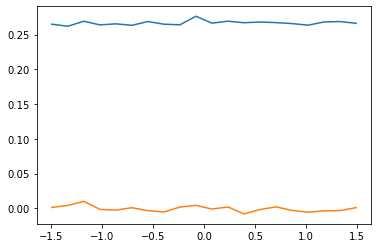

In [44]:
G_real = [0.264996, 0.2620277, 0.26921475, 0.26398763, 0.26549518, 0.26339878,
          0.26880786, 0.26499732, 0.26410058, 0.27643606, 0.26649349, 0.26934676,
          0.26708993, 0.26811769, 0.26727645, 0.26587238, 0.26357331, 0.26822787,
          0.26880807, 0.26628228]

G_imag=[0.00117877, 0.00413332, 0.01000053, -0.0015757, -0.00267252, 0.00084041,
         -0.00344657, -0.00534672, 0.00172647, 0.00421683, -0.00110167, 0.00186704,
         -0.00812697, -0.00179123, 0.00201627, -0.00308337, -0.00564529, -0.00365664,
         -0.00332637, 0.00087218]

plt.plot(av_mod,G_real,label='G_real')
plt.plot(av_mod,G_imag,label='G_imag')


In [ ]:


plt.plot(av_mod,G_real,label='G_real')

In [37]:
def process_frequency_bin(i,fmin,fmax,f_bin_number,weights_G,weights_ref,ps_2_ref,cs_ref_obs,cs_G_obs,av_mod,Q_norm,
                          U_norm):
    
    fspace = np.linspace(fmin, fmax, f_bin_number + 1)
    f_min_array, f_max_array = fspace[:-1], fspace[1:]
    f_angle_list = list(zip(f_min_array, f_max_array))
    av_f = (f_min_array + f_max_array) / 2
    av_f_err = (f_max_array - f_min_array) / 2
    f_min = f_angle_list[i][0]
    f_max = f_angle_list[i][1]


    G_real = np.average([[cs.power.real[(fmin <= cs.freq) & (cs.freq <= fmax)].mean() for cs in sublist] for sublist in cs_G_obs],weights=weights_G,axis=0)
    print('G real',G_real)
    
    G_imag = np.average([[cs.power.imag[(fmin <= cs.freq) & (cs.freq <= fmax)].mean() for cs in sublist] for sublist in cs_G_obs],weights=weights_G,axis=0)
    print('G imag',G_imag)
    cs_ref_real_mean=np.average([cs_ref.power.real[(fmin <= cs_ref.freq) & (cs_ref.freq <= fmax)].mean() for cs_ref in cs_ref_obs],weights=weights_ref,axis=0)
    cs_ref_imag_mean=np.average([cs_ref.power.imag[(fmin <= cs_ref.freq) & (cs_ref.freq <= fmax)].mean() for cs_ref in cs_ref_obs],weights=weights_ref,axis=0)
    cs_ref_average=cs_ref_real_mean+1j*cs_ref_imag_mean
    cs_ref_abs_mean_stack=np.abs(cs_ref_average)


    #ps_2_ref_mean=ps_2_ref.power[(f_min<=ps_2_ref.freq) & (ps_2_ref.freq<=f_max)].mean()
    

    #cs_ref_real_mean=np.array(cs_ref_real_stacked[(f_min<=cs_ref.freq) & (cs_ref.freq<=f_max)].mean())
    #cs_ref_im_mean=np.array(cs_ref_imag_stacked[(f_min<=cs_ref.freq) & (cs_ref.freq<=f_max)].mean())


    #cs_ref_complex_mean=cs_ref_real_mean+1j*cs_ref_im_mean
    #c#s_ref_abs_mean_stack=np.abs(cs_ref_complex_mean)
        
    #G_real=cs_G_stacked.power.real[(f_min<=cs_G_stacked.freq) & (cs_G_stacked.freq<=f_max)].mean()
    #G_imag=cs_G_stacked.power.imag[(f_min<=cs_G_stacked.freq) & (cs_G_stacked.freq<=f_max)].mean()
  
    J=20
    #Fit real and im parts of G
    parameters_real,pcovreal=curve_fit(cross_spec_model_real,np.array(av_mod),np.array(G_real))
    print(parameters_real)
    
    fit_real = cross_spec_model_real(np.array(av_mod),parameters_real[0],parameters_real[1],parameters_real[2])

    parameters_imag,pcovimag=curve_fit(cross_spec_model_imag,np.array(av_mod),np.array(G_imag))
   
    fit_imag = cross_spec_model_imag(np.array(av_mod),parameters_imag[0],parameters_imag[1])

    Areal_err,Breal_err,Creal_err= np.sqrt(np.diag(pcovreal))
   
    Bimag_err,Cimag_err= np.sqrt(np.diag(pcovimag))
   
    #Calculating null hypothesis
    G_null=cross_spec_model_null(np.array(av_mod),cs_ref_abs_mean_stack,Q_norm,U_norm)
    G_null_real=G_null.real
    G_null_imag=G_null.imag

    #Null hypothesis co-efficients
    A_null_real=cs_ref_abs_mean_stack
    B_null_real=cs_ref_abs_mean_stack*Q_norm
    C_null_real=cs_ref_abs_mean_stack*U_norm
    B_null_imag=0
    C_null_imag=0
 


# [All code currently in your loop goes here, unmodified]
# Replace `.append()` calls with return values instead

    result = {
    "A_real_err": Areal_err,
    "B_real_err": Breal_err,
    "C_real_err": Creal_err,
    "B_imag_err": Bimag_err,
    "C_imag_err": Cimag_err,
    "B_imag": parameters_imag[0],
    "C_imag": parameters_imag[1],
    "A_null_real": A_null_real,
    "B_null_real": B_null_real,
    "C_null_real": C_null_real,
    "B_null_imag": B_null_imag,
    }   

    return result
